<h1><b><i>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; German Traffic Sign Detection and Recognition</i></b></h1> 

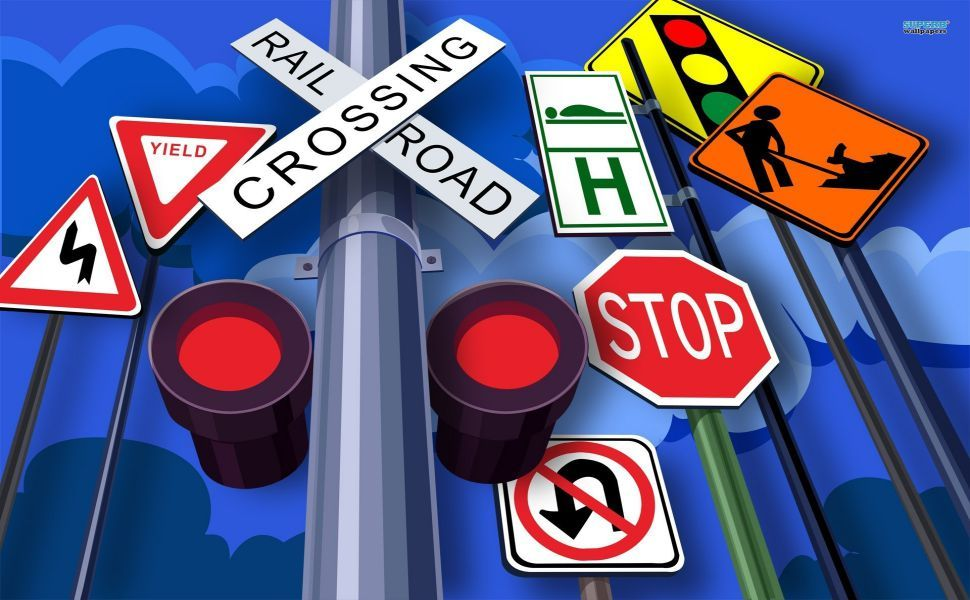

In [0]:
Image("/content/TrafficSignal.jpg", width=1200)

# 1. Business/ Real-world constraints :

## 1.1. Problem Statement :

<p>
• Traffic signs are an integral part of our road infrastructure. Without such useful signs, 
we would most likely be faced with more accidents, as drivers would not be given critical 
feedback on how fast they could safely go, or informed about road works, sharp turn, or 
school crossings ahead.
<br><br>
• Naturally, autonomous vehicles must also abide by road legislation and therefore recognize and understand traffic signs.
<br><br>
• The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held 
at the International Joint Conference on Neural Networks (IJCNN) 2011.
</p>

## 1.2. Objectives and constraints :

• Each traffic sign should be correctly identified. Hence, multi-class log-loss should be improved.
<br><br>
• Also, time is a major constraint here because a delay of even a second can be a matter of life and death.<br>

## 1.3. Useful References :

• <a href="http://benchmark.ini.rub.de/?section=home&subsection=news">INI Benchmark Website</a>
<br><br>
• <a href="https://cg.cs.tsinghua.edu.cn/traffic-sign/">Traffic sign detection and classification in the wild</a>
<br><br>
• <a href="https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign">Kaggle page to download the dataset</a>
<br><br>

• <a href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html">Building a very powerful image classification model with very little data</a>
<br><br>

In [0]:
#Importing essential libraries
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns
import cv2
import os
import datetime
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import ImageEnhance, Image 
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [0]:
#Defining essential functions

def download_dataset_from_kaggle() :
  '''
  This function downloads the German traffic sign
  dataset from kaggle and stores it in temporary
  session memory of google colab and unzips it.
  '''
  #Upload the kaggle api token
  print("Please upload the kaggle api token :")
  files.upload() #this will prompt you to update the json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

  #Downloading and unzipping the dataset
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip /content/gtsrb-german-traffic-sign.zip -d Data

#---------------------------------------------------------------------------------------------------------------------------------------------------

def plot_image_path(path) :
  '''
  Takes path of an image
  as input and plots the image.
  '''
  image = cv2.imread(path)
  print("Image Dimensions : {0}".format(image.shape))
  image = Image.fromarray(image, 'RGB')
  plt.imshow(image, interpolation='nearest')
  plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------

def load_train_images() :
  '''
  This functions loads train images into a numpy
  array and returns it. It also returns the train
  labels.
  '''
  #Reading the input images and storing then into numpy.ndarray
  n_classes = 43
  data = []
  labels = []
  #Reading the train images
  for itr in range(n_classes) :
    path = '/content/Data/Train/{0}/'.format(itr)
    Class = os.listdir(path)
    for c in Class :
      image = cv2.imread(path + c)
      image = Image.fromarray(image)
      data.append(np.array(image))
      labels.append(itr)
  data=np.array(data)
  labels=np.array(labels)
  return data, labels

#---------------------------------------------------------------------------------------------------------------------------------------------------

def randomize_data(data, labels) :
  '''
  This function simply randomizes the
  order of the images and labels and
  returns them.
  '''
  s=np.arange(data.shape[0])
  np.random.shuffle(s)
  data=data[s]
  labels=labels[s]
  return data, labels

#---------------------------------------------------------------------------------------------------------------------------------------------------

def split_data(data, labels, val_size) :
  '''
  This function splits the train data
  into a train and validation sets and returns them.
  It performs one-hot encoding on labels before returning them.
  '''
  #Splitting images into train and validation sets
  (X_train, X_val) = data[(int)(val_size*len(labels)):], data[:(int)(val_size*len(labels))]
  #Normalization
  X_train = X_train.astype('float32')/255 
  X_val = X_val.astype('float32')/255
  #Splitting labels
  (y_train, y_val) = labels[(int)(val_size*len(labels)):], labels[:(int)(val_size*len(labels))]
  #Performing OneHotEncoding
  enc = OneHotEncoder()
  enc.fit(y_train.reshape(-1,1))
  y_train = enc.transform(y_train.reshape(-1,1))
  y_val = enc.transform(y_val.reshape(-1,1))
  y_train = y_train.toarray()
  y_val = y_val.toarray()
  return X_train, X_val, y_train, y_val

#---------------------------------------------------------------------------------------------------------------------------------------------------

def img_dims_donut_chart(data) :
  '''
  This function takes images in the form of arrays
  as input and plots a donut chart to show what
  proportion of these images lies within certain dimension range.
  '''
  img_size_dict = {
    "b/w_16_&_32" : 0,
    "b/w_32_&_64" : 0,
    "b/w_64_&_128" : 0,
    "b/w_128_&_256" : 0,
    }
  for img in data :
    if (img.shape[0] > 16 and img.shape[1] > 16) and (img.shape[0] < 32 and img.shape[1] < 32) :
      img_size_dict['b/w_16_&_32'] += 1
    elif (img.shape[0] > 32 and img.shape[1] > 32) and (img.shape[0] < 64 and img.shape[1] < 64) :
      img_size_dict['b/w_32_&_64'] += 1
    elif (img.shape[0] > 64 and img.shape[1] > 64) and (img.shape[0] < 128 and img.shape[1] < 128) :
      img_size_dict['b/w_64_&_128'] += 1
    elif (img.shape[0] > 128 and img.shape[1] > 128) and (img.shape[0] < 256 and img.shape[1] < 256) :
      img_size_dict['b/w_128_&_256'] += 1
  categories = ["Between 16 & 32", "Between 32 & 64", "Between 64 & 128", "Between 128 & 256"]
  sizes = [4766, 23232, 5841, 518]
  my_circle=plt.Circle( (0,0), 0.6, color='white')
  fig = plt.figure(figsize=(8,8))
  plt.pie(sizes, labels=categories, colors=['red','green','blue','skyblue'], shadow=True)
  plt.title("Size range of train images")
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  fig.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------

def channel_count(data) :
  '''
  Counts the number of channels in
  each of the images in the set.
  '''
  n_channels = []
  ret_dict = {}
  for itr in range(len(data)) :
    img = data[itr]
    if img.ndim == 2 :
      channels = 1
    if img.ndim == 3 :
      channels = img.shape[-1]
    n_channels.append(channels)
  tmp = set(n_channels)
  for ele in tmp :
    ret_dict[ele] = n_channels.count(ele)
  return ret_dict

In [0]:
#Downloading dataset from kaggle
download_dataset_from_kaggle()

# 2. Exploratory data analysis :

In [0]:
#Train.csv contains information regarding each train image
df_train = pd.read_csv('/content/Data/Train.csv')
labels_train = df_train['ClassId']

#Test.csv contains information regarding each test image
df_test = pd.read_csv('/content/Data/Test.csv')
labels_test = df_test['ClassId']
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [0]:
print("No of images in train data : {0}".format(df_train.shape[0]))
print("No of images in test data : {0}".format(df_test.shape[0]))

No of images in train data : 39209
No of images in test data : 12630


## 2.1. Checking for class imbalance :

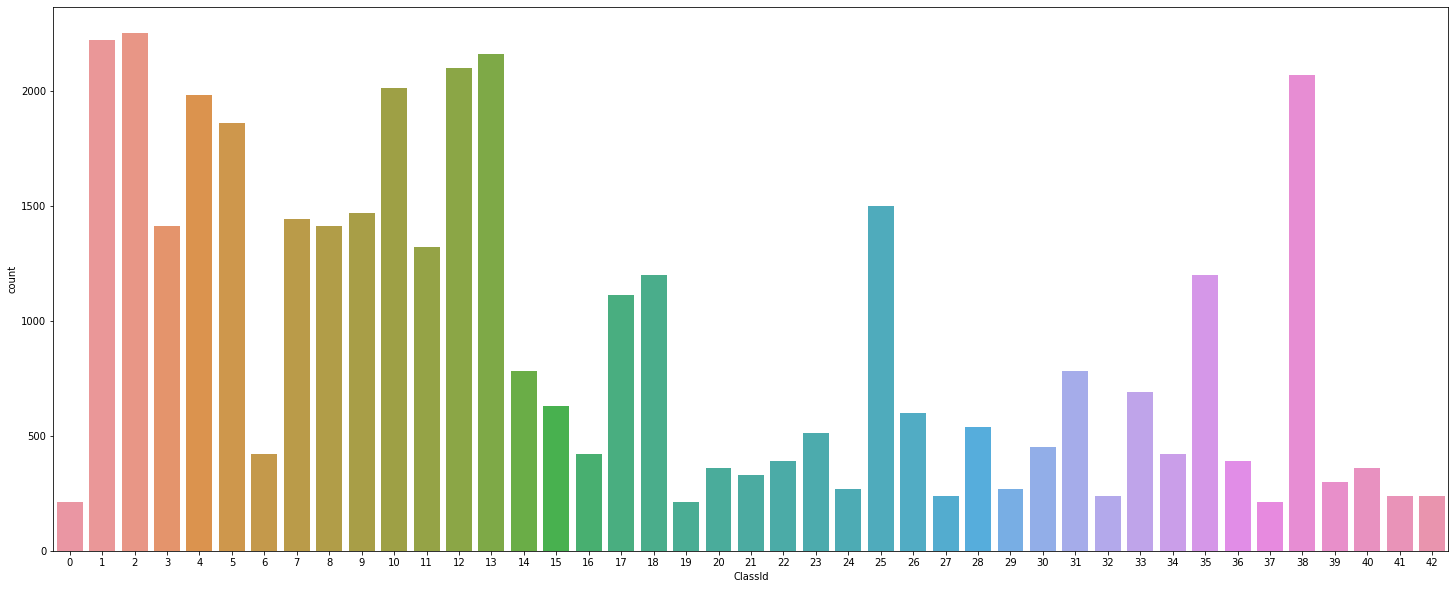

In [0]:
#Checking class distribution in train data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = df_train, x = 'ClassId', )
plt.show()

<h2>Observations :</h2>
<p>
<ul>
  <li>
  The target classes are clearly not uniformly distributed. 
  </li>
  <li>
  This is quite logical since some signs like "Keep speed below 30Kmph" or "A bump ahead" appears more often then signs like "Road under construction ahead".
  </li>
  <li>
  Also, for most of the classes, the imbalance is not severe.
  </li>
</ul>
</p>

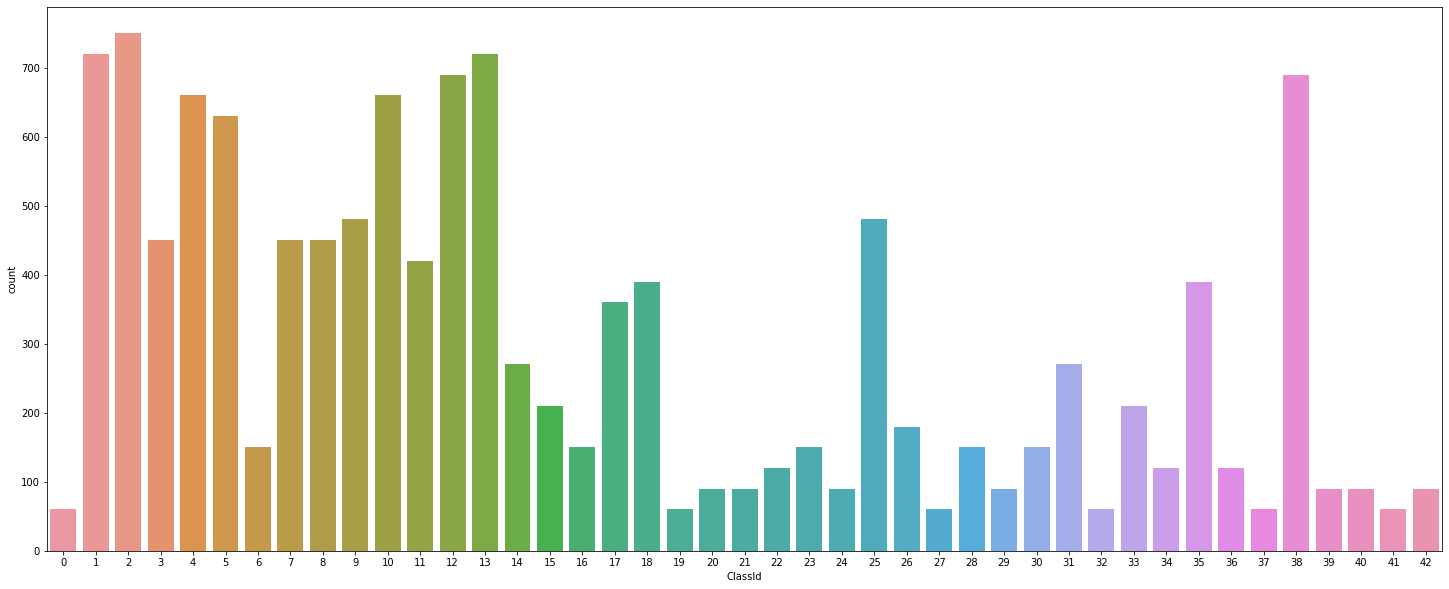

In [0]:
#Checking class distribution in test data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = df_test, x = 'ClassId', )
plt.show()

<h2>Observations :</h2>
<p>
<ul>
  <li>
  The observations for test data are quite similer to that of the train data.
  </li>
  <li>
  Here also some classes are more frequent as compared to the others.
  </li>
</ul>
</p>

## 2.2. Dealing with different image dimensions :

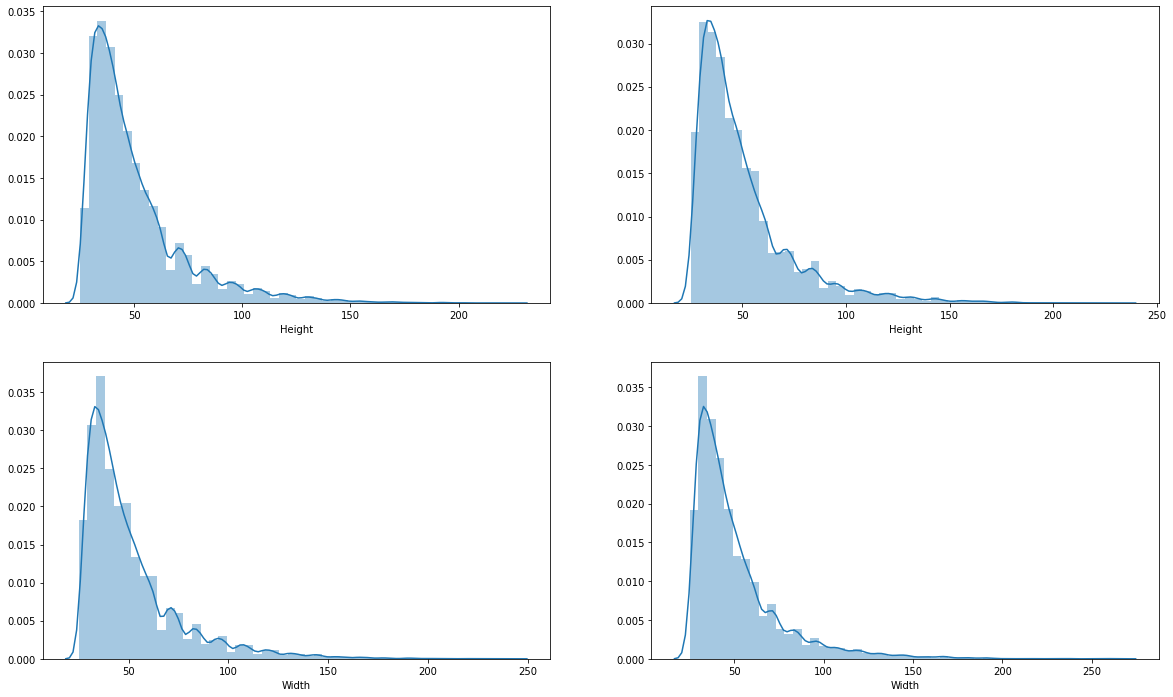

In [0]:
#Distplot for Height and Width of images in train data
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((20,12))
sns.distplot(df_train['Height'], ax = ax[0][0])
fig.set_size_inches((20,12))
sns.distplot(df_test['Height'], ax = ax[0][1])
fig.set_size_inches((20,12))
sns.distplot(df_train['Width'], ax = ax[1][0])
fig.set_size_inches((20,12))
sns.distplot(df_test['Width'], ax = ax[1][1])
plt.show()


<h2>Observations :</h2>
<p>
<ul>
  <li>
  It is evident from the above figures that both our train and test set images follow similer Height and Width distribution.
  </li>
  <li>
  Since all the images have different dimensions,  we need to fix the height and width constant for every image to follow.
  </li>
  <li>
  We need to perform this in such a way that data loss is least.
  </li>
  <li>
  For smaller images, we will need to do appropriate padding.  
  </li>
</ul>
</p>

In [0]:
#Loading train images in numpy.ndarray
data, labels = load_train_images()

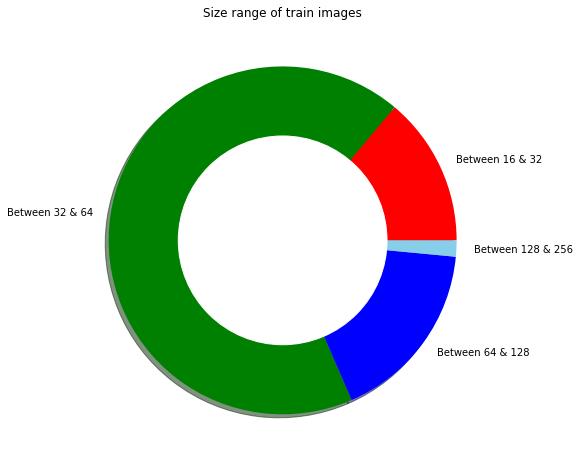

In [0]:
img_dims_donut_chart(data)

<p>
<ul>
<li>
  From the above plots, we can conclude that there are very few images that has width and height more than 128.
  </li>
  <li>
  Hence, we can safely set the size of each image to be 128*128. This won't lead to much data loss.
  </li>
  <li>
  However,  we do need to take care of appropriate padding. Padding will not be same for each image. An image with white background cannot have a black padding.
  </li>
  <li>
  Let's perform padding on an image and plot them.
  </li>
  <li>
  We will use copyMakeBorder module of OpenCV.
  </li>
</ul>
</p>

(128, 128, 3)


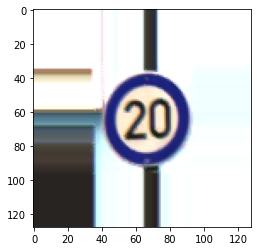

In [0]:
#Above image has dims less than 128
#Lets perform padding on above image
path = '/content/Data/Train/0/00000_00004_00007.png'
image = cv2.imread(path)
if image.shape[0] <128 :
  diff = 128 - image.shape[0]
  top = math.ceil(diff/2)
  bottom = math.floor(diff/2)
if image.shape[1] <128 :
  diff = 128 - image.shape[1]
  left = math.ceil(diff/2)
  right = math.floor(diff/2)
image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
print(image.shape)
image = Image.fromarray(image)
plt.imshow(image)
plt.show()

<p>
<ul>
  <li>
  Thus, we simply need to modify our "load_train_images" function and add above code snippet. After that all the train images loaded will have same dimensions (128*128) with appropriate padding.
  </li>
  <li>
  Also, there is a small section of images that have either height, or width or both more than 128 pixes. For that, we will use <b>Image.Crop()</b> to trim their sizes.
  </li>
</ul>
</p>

In [0]:
#Final function to load each image with same dimensions
def padding(image) :
  top, bottom, left, right = 0, 0, 0, 0
  if image.shape[0] < 128 :
    diff = 128 - image.shape[0]
    top = math.ceil(diff/2)
    bottom = math.floor(diff/2)
  if image.shape[1] < 128 :
    diff = 128 - image.shape[1]
    left = math.ceil(diff/2)
    right = math.floor(diff/2)
  image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
  return image
def truncate(image) :
  image = image[0:128, 0:128]
  return image
def load_train_images_preprocessed() :
  '''
  -> This functions loads train images into a numpy
     array in such a way that each image has same dimension (128*128).
  -> It performs padding and truncating on the input images.
  '''
  #Reading the input images and storing then into numpy.ndarray
  n_classes = 43
  data = []
  labels = []
  #Reading the train images
  for itr in tqdm(range(n_classes)) :
    path = '/content/Data/Train/{0}/'.format(itr)
    Class = os.listdir(path)
    for c in Class :
      image = cv2.imread(path + c)
      image = padding(image)
      image = truncate(image)
      image = Image.fromarray(image, 'RGB')
      data.append(np.array(image))
      labels.append(itr)
  data=np.array(data)
  labels=np.array(labels)
  return data, labels

In [0]:
#Loading the preprocessed images
import random
import math
data_preprocessed, new_labels = load_train_images_preprocessed()

100%|██████████| 43/43 [00:11<00:00,  3.60it/s]


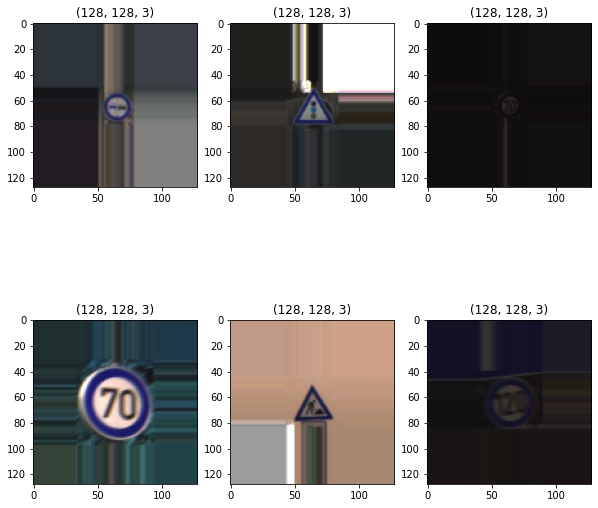

In [0]:
#randomly plotting the preprocessed images
fig, ax = plt.subplots(2,3)
height, width = 10, 10

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[0][0].title.set_text(data_preprocessed[seed].shape)
ax[0][0].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[0][1].title.set_text(data_preprocessed[seed].shape)
ax[0][1].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[0][2].title.set_text(data_preprocessed[seed].shape)
ax[0][2].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[1][0].title.set_text(data_preprocessed[seed].shape)
ax[1][0].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[1][1].title.set_text(data_preprocessed[seed].shape)
ax[1][1].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[1][2].title.set_text(data_preprocessed[seed].shape)
ax[1][2].imshow(data_preprocessed[seed])

*   The above images may seem distorted because these images were originally small and they are padded with the nearest pixels.
*   We will get rid of this problem when we preform data augmentation. There we will have a zoomed and brighter versions for each images.
*   Here our goal is to simply get same dimension for each image.



# Image Channels :

In [0]:
#Counting number of channels in each images in train set
n_channels = channel_count(data)
for idx, ele in n_channels.items() :
  print("There are {0} {1}-channeled images".format(ele, idx))

There are 39209 3-channeled images


<p>
<ul>
  <li>
  All the images in the train set are 3-channeled RGB images.
  </li>
</ul>
</p>

## Dealing with bright and dark images :

<p>
  <ul>
    <li>
    In the dataset, there are some images that are very bright and some images that are very dark.
    </li>
  </ul>
</p>

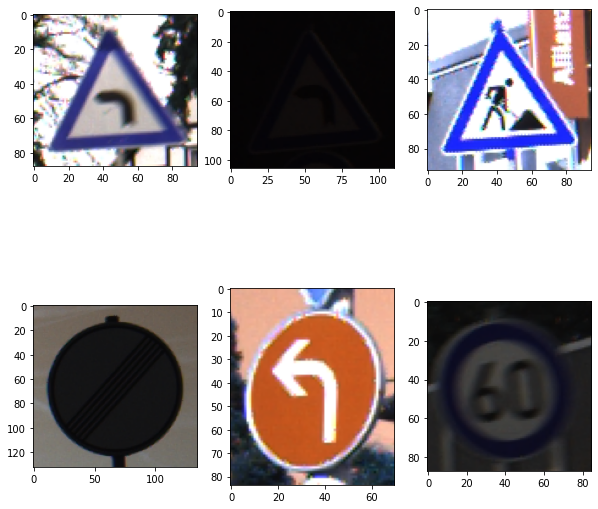

In [0]:
height, width = 10, 10
fig, ax = plt.subplots(2,3)
fig.set_size_inches(height, width)
image = cv2.imread("/content/Data/Train/19/00019_00003_00027.png")
image = Image.fromarray(image)
ax[0][0].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("/content/Data/Train/19/00019_00004_00029.png")
image = Image.fromarray(image)
ax[0][1].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("/content/Data/Train/25/00025_00000_00026.png")
image = Image.fromarray(image)
ax[0][2].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("/content/Data/Train/32/00032_00000_00029.png")
image = Image.fromarray(image)
ax[1][0].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("/content/Data/Train/34/00034_00000_00028.png")
image = Image.fromarray(image)
ax[1][1].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("/content/Data/Train/3/00003_00000_00028.png")
image = Image.fromarray(image)
ax[1][2].imshow(image)

<p>
  <ul>
    <li>
    We will tackle this problem with data augmentation.
    </li>
    <li>
    <a href="https://www.geeksforgeeks.org/python-data-augmentation/">Data Augmentation in python.</a>
    </li>
    <li>
    <a href = "https://kite.com/python/examples/3186/pil-increase-the-brightness-of-an-image">PIL ImageEnhance</a>
    </li>
  </ul>
</p>

In [0]:
im = Image.open('/content/Data/Train/19/00019_00004_00029.png')
enhancer = ImageEnhance.Brightness(im)
enhanced_im1 = enhancer.enhance(10)
im = Image.open("/content/Data/Train/32/00032_00000_00029.png")
enhancer = ImageEnhance.Brightness(im)
enhanced_im2 = enhancer.enhance(10)

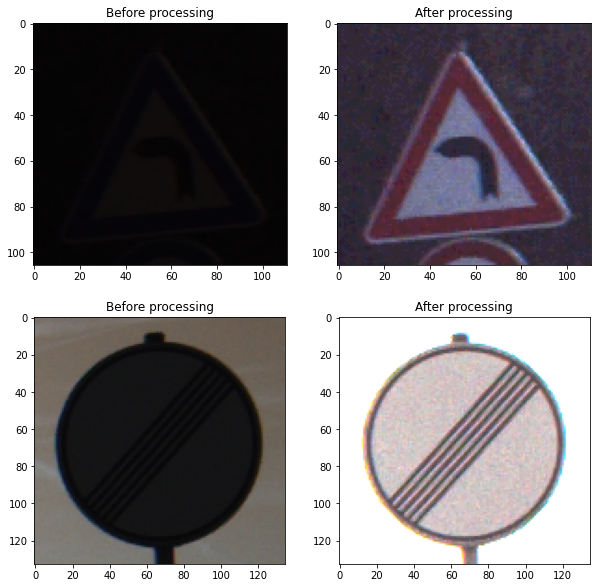

In [0]:
height, width = 10, 10
fig, ax = plt.subplots(2,2)
fig.set_size_inches(height, width)

image = cv2.imread('/content/Data/Train/19/00019_00004_00029.png')
image = Image.fromarray(image)
ax[0][0].title.set_text('Before processing')
ax[0][0].imshow(image)
ax[0][1].title.set_text('After processing')
ax[0][1].imshow(enhanced_im1)

image = cv2.imread("/content/Data/Train/32/00032_00000_00029.png")
image = Image.fromarray(image)
ax[1][0].title.set_text('Before processing')
ax[1][0].imshow(image)
ax[1][1].title.set_text('After processing')
ax[1][1].imshow(enhanced_im2)

plt.show()



*   Similerly, we can get zoomed version of an image, can manipulate contrast, brightness e.t.c.
*   We will use <a href = "https://keras.io/preprocessing/image/">ImageDataGenerator</a> from keras.preprocessing.image to generate different versions for each input image.
*   Because of this, we will have a larger dataset as well as different variations for each image. This will help our model to learn better.
*   Visit this <a href = "https://www.geeksforgeeks.org/python-data-augmentation/">GeeksForGeeks</a> link for more on data augmentation in python






